In [94]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from glob import glob
import pickle
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [204]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,cohen_kappa_score,roc_curve,auc

#### Crop the Images

In [3]:
fpath = glob("./data/female/*.jpg")
mpath = glob("./data/male/*.jpg")

In [14]:
haar = cv2.CascadeClassifier("./model/haarcascade_frontalface_default.xml")


def extract_images(path,haar,gender,num):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = haar.detectMultiScale(gray,1.5,3)
    for x,y,w,h in faces:
        crop_img = img[y:y+h,x:x+h]
        if gender == "female":
            cv2.imwrite(f"./data/crop_female/{gender}_{num}.png",crop_img)
        else:
            cv2.imwrite(f"./data/crop_male/{gender}_{num}.png",crop_img)

In [15]:
#Crop whole images
for i,path in enumerate(fpath):
    extract_images(path,haar,"female",i)
    
for i,path in enumerate(mpath):
    extract_images(path,haar,"male",i)

In [21]:
#Scaling the cropped images. All of them have different h,w ratio. Check for the least and take it as a standard
cfpath= glob("./data/crop_female/*.png")
cmpath= glob("./data/crop_male/*.png")
path = cmpath + cfpath

#### Resize the Images

In [25]:
#Get size of image
def size(path):
    img = Image.open(path)
    return img.size[0] #taking either h or w is enough as its square matrix

In [28]:
#Convert to df
data = pd.DataFrame(path,columns = ["path"])
data["size"] = data["path"].apply(lambda x: size(x))
data.head()

,path,size
0,./data/crop_male\male_0.png,182
1,./data/crop_male\male_1.png,122
2,./data/crop_male\male_1003.png,81
3,./data/crop_male\male_1005.png,122
4,./data/crop_male\male_1007.png,273


In [48]:
path[3134]

'./data/crop_female\\female_1148.png'

In [29]:
#EDA
data.shape
data.info()
data.describe() #check max and min wdth

(7237, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7237 entries, 0 to 7236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    7237 non-null   object
 1   size    7237 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 113.2+ KB


,size
count,7237.000000
mean,153.781401
std,74.497387
min,24.000000
25%,81.000000
50%,122.000000
75%,182.000000
max,410.000000


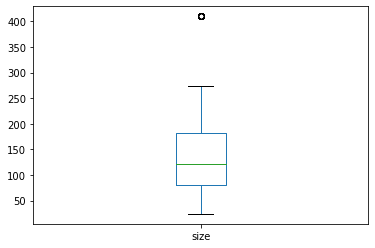

In [51]:
data["size"].plot(kind="box")

(array([  48.,    0.,  773.,    0., 1247.,    0.,    0., 1766.,    0.,
           0.,    0.,    0., 1978.,    0.,    0.,    0.,    0.,    0.,
           0., 1395.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,   30.]),
 array([ 24.        ,  36.86666667,  49.73333333,  62.6       ,
         75.46666667,  88.33333333, 101.2       , 114.06666667,
        126.93333333, 139.8       , 152.66666667, 165.53333333,
        178.4       , 191.26666667, 204.13333333, 217.        ,
        229.86666667, 242.73333333, 255.6       , 268.46666667,
        281.33333333, 294.2       , 307.06666667, 319.93333333,
        332.8       , 345.66666667, 358.53333333, 371.4       ,
        384.26666667, 397.13333333, 410.        ]),
 <a list of 30 Patch objects>)

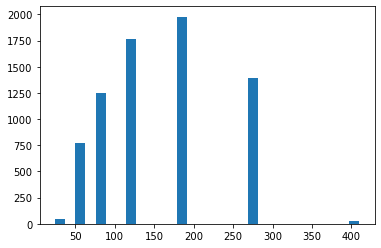

In [52]:
plt.hist(data["size"],bins = 30) #lets consider above 60,as the major part falls there. Resize to 100*100


In [54]:
df = data[data["size"] > 60]
df.head()
df.shape

,path,size
0,./data/crop_male\male_0.png,182
1,./data/crop_male\male_1.png,122
2,./data/crop_male\male_1003.png,81
3,./data/crop_male\male_1005.png,122
4,./data/crop_male\male_1007.png,273


(6416, 2)

In [68]:
# x = df.iloc[1,0]
# x.split("_")[1].split("\\")[-1]

'male'

In [69]:
#Adding the target column for classification

df["gender"] = df["path"].apply(lambda x:x.split("_")[1].split("\\")[-1])

In [72]:
df["gender"].value_counts()
df["gender"].value_counts(normalize = True)

female    3757
male      2659
Name: gender, dtype: int64

female    0.585567
male      0.414433
Name: gender, dtype: float64

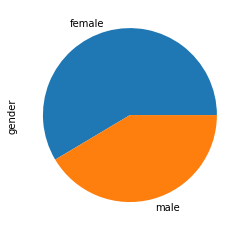

In [71]:
df["gender"].value_counts().plot(kind="pie") #Major female

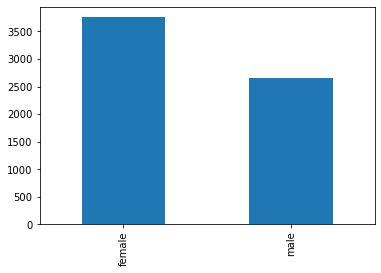

In [73]:
df["gender"].value_counts().plot(kind="bar")

In [74]:
#ratio is 60:40 which is acceptable, hence consider as balanced dataset.
df["size"].min()

81

In [84]:
#Image resize

def resize(row):
    try:
        img = cv2.imread(row)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        size = gray.shape[0]
        if size >= 100: 
            res = cv2.resize(gray,(100,100),cv2.INTER_AREA) #Shrink
        else:
            res = cv2.resize(gray,(100,100),cv2.INTER_CUBIC) #Expand
        flat_img = res.flatten()
        return flat_img
    except:
        return None

In [85]:
df["resize"] = df["path"].apply(resize)

In [86]:
df.head()

,path,size,gender,resize
0,./data/crop_male\male_0.png,182,male,"[106, 100, 81, 69, 71, 48, 51, 55, 41, 17, 30,..."
1,./data/crop_male\male_1.png,122,male,"[49, 50, 49, 50, 50, 48, 47, 47, 46, 48, 50, 4..."
2,./data/crop_male\male_1003.png,81,male,"[165, 184, 209, 224, 220, 211, 193, 170, 153, ..."
3,./data/crop_male\male_1005.png,122,male,"[141, 143, 148, 156, 161, 173, 157, 138, 146, ..."
4,./data/crop_male\male_1007.png,273,male,"[180, 115, 41, 103, 23, 25, 36, 35, 25, 31, 38..."


In [89]:
df.shape

(6416, 4)

In [88]:
df1 = df["resize"].apply(pd.Series)
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,106,100,81,69,71,48,51,55,41,17,...,17,18,26,28,31,30,31,29,31,31
1,49,50,49,50,50,48,47,47,46,48,...,138,139,140,142,145,147,151,148,138,130
2,165,184,209,224,220,211,193,170,153,148,...,14,14,14,13,13,14,14,14,14,15
3,141,143,148,156,161,173,157,138,146,121,...,205,203,173,86,72,60,46,59,88,148
4,180,115,41,103,23,25,36,35,25,31,...,112,110,104,112,86,83,116,126,111,113


In [91]:
#Data to be trained
df2 = pd.concat((df["gender"],df1),axis=1)
df2.head()
df2.shape

,gender,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,male,106,100,81,69,71,48,51,55,41,...,17,18,26,28,31,30,31,29,31,31
1,male,49,50,49,50,50,48,47,47,46,...,138,139,140,142,145,147,151,148,138,130
2,male,165,184,209,224,220,211,193,170,153,...,14,14,14,13,13,14,14,14,14,15
3,male,141,143,148,156,161,173,157,138,146,...,205,203,173,86,72,60,46,59,88,148
4,male,180,115,41,103,23,25,36,35,25,...,112,110,104,112,86,83,116,126,111,113


(6416, 10001)

Text(0.5, 1.0, 'Label: male')

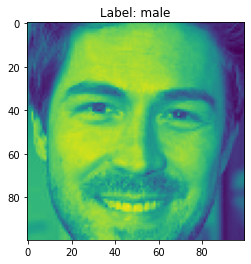

In [93]:
#check one image with the flattened array values
plt.imshow(df2.iloc[0,1:].values.reshape(100,100).astype("int"))
plt.title("Label: "+df2.iloc[0,0])

In [103]:
#Save the df in pickle format
pickle.dump(df2,open('./data/df_100_100.pkl','wb'))

#### Data Cleaning

In [106]:
#Data Cleaning and Preparation 
df2.info()
df2.isnull().sum() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6416 entries, 0 to 7236
Columns: 10001 entries, gender to 9999
dtypes: object(1), uint8(10000)
memory usage: 61.6+ MB


gender    0
0         0
1         0
2         0
3         0
         ..
9995      0
9996      0
9997      0
9998      0
9999      0
Length: 10001, dtype: int64

In [107]:
# Data Normalization
#many outliers = std scaling
#no or less outliers = min max scaling

X = df2.iloc[:,1:].values
y = df2.iloc[:,0].values

In [109]:
X.shape
y.shape

(6416, 10000)

(6416,)

##### MIN MAX SCALER
##### Xnorm = $\frac{x-minVal} {maxVal - minVal}$

In [111]:
X.min() 
X.max()

0

255

In [112]:
Xnorm = X/X.max()
Xnorm.shape

(6416, 10000)

In [114]:
ynorm = np.where(y == "female",1,0)
ynorm

array([0, 0, 0, ..., 1, 1, 1])

In [115]:
#Save X and y norms
np.savez("./data/data_100_norm",Xnorm,ynorm)

#Load
# data = np.load("./data/data_100_norm")
# data.files #will give a list of arrays that were saved.
# X = data["arr_0"]
# y = data["arr_1"]

#### Eigen Image Creation

In [121]:
#Do PCA and reduce dimensions
X1 = X - X.mean(axis=0)
pca = PCA(n_components = None, whiten = True, svd_solver = "auto")
# variance,direction = eigen values, eigen vectors, pca calculates this from covariance.
# Large variance means more info and hence PCA intends to get max variance or ncompnents

x_pca = pca.fit_transform(X1)
x_pca.shape #SVD solver reduces the shape to row size.


(6416, 6416)

In [119]:
eigen_ratio = pca.explained_variance_ratio_
eigen_ratio_cum = np.cumsum(eigen_ratio)

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'No. of Components')

Text(0, 0.5, 'Explained Variance Ratio')

Text(0.5, 0, 'No. of Components')

Text(0, 0.5, 'Explained Variance Ratio')

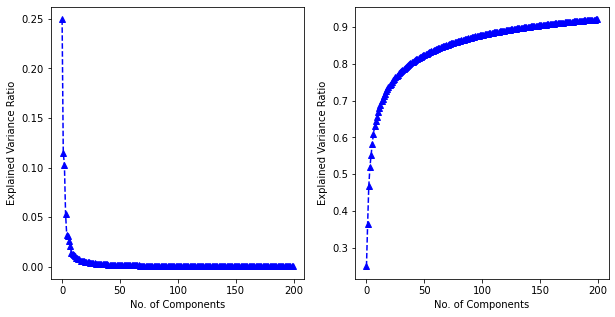

In [120]:

#Elbow method to identify n_components
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(eigen_ratio[:200],"b^--")
plt.xlabel("No. of Components")
plt.ylabel("Explained Variance Ratio")
plt.subplot(1,2,2)
plt.plot(eigen_ratio_cum[:200],"b^--")
plt.xlabel("No. of Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

# Image 1 shows 1st comp has 25%variance, 3rd component has 10%variance.
# Image 2 shows cumulative approach, ie. if we take 1 comp it ll give 25%var, 3comps ll give nearly 50%var, 50comps almost 80%var
#This is how we do dimensionality reduction. Best is 75 - 80%variance. If u have more consider that.

In [122]:
pca_50 = PCA(n_components = 50, whiten = True, svd_solver = "auto")

x_pca_50 = pca_50.fit_transform(X1)
x_pca_50.shape 


(6416, 50)

In [124]:
# Eigen Image = PCA applied to images to reduce dimensions/components
# Initially it had 10k directions and now it has 50
#Save pca
pickle.dump(x_pca_50,open("./data/x_pca_50.pkl","wb"))

In [126]:
#Create EIGEN FACE

#Consider 50 and do inverse transform (Transform back to 10k directions, but this time it will have zeros in 9950 directions)
x_pca_inv = pca_50.inverse_transform(x_pca_50)
x_pca_inv.shape

(6416, 10000)

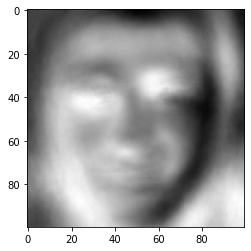

In [131]:
#Consider one image
eig_img = x_pca_inv[2000,:]
eig_img = eig_img.reshape((100,100))
plt.imshow(eig_img,cmap="gray")

In [128]:
# saving 
np.savez('./data/pca_50_mean.pickle',pca_50,X.mean(axis=0))

#### Data Preparation

In [132]:
X = x_pca_50
mean = X.mean(axis=0)
y = ynorm

In [186]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((5132, 50), (1284, 50), (5132,), (1284,))

#### SVM - Model Training

In [191]:
#SVM Model

model = SVC(C=1.0,kernel='rbf',gamma=0.01,probability=True,)
model.fit(x_train,y_train)
model.score(x_train,y_train)
model.score(x_test,y_test)

SVC(gamma=0.01, probability=True)

0.8406079501169135

0.7624610591900312

#### Model Evaluation

In [192]:
#SVM does not give proabability, it works as max margin classifier. But as prob is needed for auc,roc give the param prob in svm

In [193]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)

In [194]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[349, 183],
       [122, 630]], dtype=int64)

In [195]:
cm = np.concatenate((cm,cm.sum(axis =0).reshape(1,-1)),axis =0)
cm

array([[349, 183],
       [122, 630],
       [471, 813]], dtype=int64)

In [196]:
cm = np.concatenate((cm,cm.sum(axis =1).reshape(-1,1)),axis =1)
cm #1284 total y samples
#Row wise, out of 532, 362 correct and 170 incorrect

array([[ 349,  183,  532],
       [ 122,  630,  752],
       [ 471,  813, 1284]], dtype=int64)

Text(0, 0, '349')

Text(1, 0, '183')

Text(2, 0, '532')

Text(0, 1, '122')

Text(1, 1, '630')

Text(2, 1, '752')

Text(0, 2, '471')

Text(1, 2, '813')

Text(2, 2, '1284')

([<matplotlib.axis.XTick at 0x21a1770ba88>,
 <a list of 2 Text major ticklabel objects>)

([<matplotlib.axis.YTick at 0x21a176e4e88>,
 <a list of 2 Text major ticklabel objects>)

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'True Values')

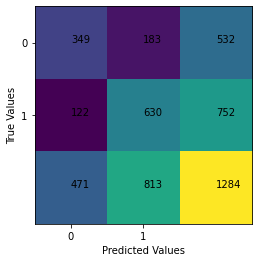

In [198]:
cm = confusion_matrix(y_test,y_pred)
cm = np.concatenate((cm,cm.sum(axis=0).reshape(1,-1)),axis=0)
cm = np.concatenate((cm,cm.sum(axis=1).reshape(-1,1)),axis=1)
plt.imshow(cm)
for i in range(3):
    for j in range(3):
        plt.text(j,i,'%d'%cm[i,j])
        
plt.xticks([0,1])
plt.yticks([0,1])
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [199]:
# Recall/sensitivity for Male(correct male pred/true male)
632/752 #Male

362/532 #female

0.8404255319148937

0.6804511278195489

In [200]:
#Precision - correct male/pred male

632/802 #male
362/482

0.7880299251870324

0.7510373443983402

In [201]:
# classification report
cr = classification_report(y_test,y_pred,target_names=['male','female'],output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
male,0.740977,0.656015,0.695912,532.000000
female,0.774908,0.837766,0.805112,752.000000
accuracy,0.762461,0.762461,0.762461,0.762461
macro avg,0.757942,0.746890,0.750512,1284.000000
weighted avg,0.760849,0.762461,0.759867,1284.000000


In [202]:
cohen_kappa_score(y_test,y_pred)
#preferred - above 60
# bad <50
# v poor <20
# perfect >80

0.502204121478363

<Figure size 720x432 with 0 Axes>

Text(0.0, 0.0, '1.99')

Text(0.009398496240601503, 0.16622340425531915, '0.94')

Text(0.022556390977443608, 0.2726063829787234, '0.90')

Text(0.039473684210526314, 0.3896276595744681, '0.86')

Text(0.05451127819548872, 0.48138297872340424, '0.84')

Text(0.07142857142857142, 0.5531914893617021, '0.80')

Text(0.09774436090225563, 0.598404255319149, '0.77')

Text(0.11842105263157894, 0.636968085106383, '0.73')

Text(0.13345864661654136, 0.6861702127659575, '0.70')

Text(0.15601503759398497, 0.711436170212766, '0.67')

Text(0.18045112781954886, 0.7340425531914894, '0.65')

Text(0.21052631578947367, 0.7566489361702128, '0.61')

Text(0.25, 0.776595744680851, '0.58')

Text(0.2819548872180451, 0.7992021276595744, '0.55')

Text(0.30639097744360905, 0.824468085106383, '0.51')

Text(0.3684210526315789, 0.8497340425531915, '0.46')

Text(0.40225563909774437, 0.8736702127659575, '0.43')

Text(0.4473684210526316, 0.8909574468085106, '0.39')

Text(0.5, 0.9082446808510638, '0.34')

Text(0.5507518796992481, 0.9268617021276596, '0.30')

Text(0.6071428571428571, 0.949468085106383, '0.26')

Text(0.6917293233082706, 0.9707446808510638, '0.20')

Text(0.8233082706766918, 0.9827127659574468, '0.14')

Text(1.0, 1.0, '0.00')

Text(0.5, 0, 'False Positve Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characterstics')

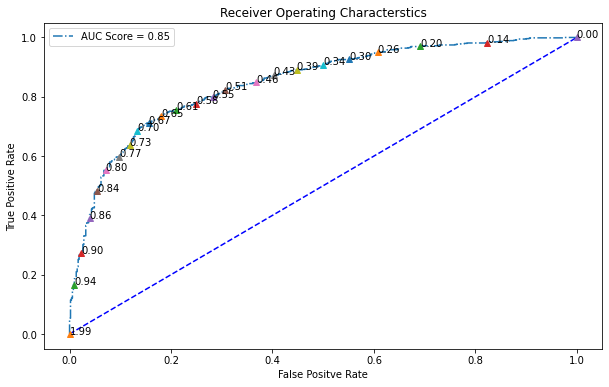

In [203]:
# roc for female
fpr,tpr,thresh = roc_curve(y_test,y_prob[:,1])
auc_s = auc(fpr,tpr)
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,'-.')
plt.plot([0,1],[0,1],'b--')
for i in range(0,len(thresh),20):
    plt.plot(fpr[i],tpr[i],'^')
    plt.text(fpr[i],tpr[i],"%0.2f"%thresh[i])
    
plt.legend(['AUC Score = %0.2f'%auc_s]) #>80 is very good

plt.xlabel('False Positve Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characterstics')
plt.show()

#### Hyperparameter Tuning

In [205]:
model_tune = SVC()
param_grid = {'C':[1,10,20,30,50,100],
             'kernel':['rbf','poly'],
             'gamma':[0.1,0.05,0.01,0.001,0.002,0.005],
             'coef0':[0,1],
             }
model_grid = GridSearchCV(model_tune,param_grid=param_grid,scoring='accuracy',cv=5)
model_grid.fit(X,y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 20, 30, 50, 100], 'coef0': [0, 1],
                         'gamma': [0.1, 0.05, 0.01, 0.001, 0.002, 0.005],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy')

In [206]:
model_grid.best_params_
model_grid.best_score_

{'C': 1, 'coef0': 0, 'gamma': 0.05, 'kernel': 'rbf'}

0.7640276755948261

In [207]:
model_best = SVC(C=1,kernel='rbf',gamma=0.05,probability=True)
model_best.fit(x_train,y_train)
model_best.score(x_test,y_test)

SVC(C=1, gamma=0.05, probability=True)

0.8029595015576324

In [208]:
y_pred = model_best.predict(x_test)
y_prob = model_best.predict_proba(x_test) # proability

Text(0, 0, '372')

Text(1, 0, '160')

Text(2, 0, '532')

Text(0, 1, '93')

Text(1, 1, '659')

Text(2, 1, '752')

Text(0, 2, '465')

Text(1, 2, '819')

Text(2, 2, '1284')

([<matplotlib.axis.XTick at 0x21a17726e08>,
 <a list of 2 Text major ticklabel objects>)

([<matplotlib.axis.YTick at 0x21a1771e708>,
 <a list of 2 Text major ticklabel objects>)

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'True Values')

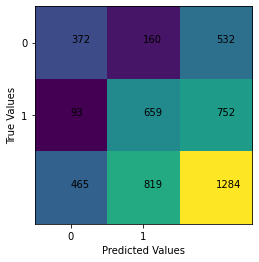

In [209]:
cm = confusion_matrix(y_test,y_pred)
cm = np.concatenate((cm,cm.sum(axis=0).reshape(1,-1)),axis=0)
cm = np.concatenate((cm,cm.sum(axis=1).reshape(-1,1)),axis=1)
plt.imshow(cm)
for i in range(3):
    for j in range(3):
        plt.text(j,i,'%d'%cm[i,j])
        
plt.xticks([0,1])
plt.yticks([0,1])
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [210]:
# Recall/sensitivity for Male(correct male pred/true male)
632/752 #Male

362/532 #female

0.8404255319148937

0.6804511278195489

In [211]:
#Precision - correct male/pred male

632/802 #male
362/482

0.7880299251870324

0.7510373443983402

In [212]:
# classification report
cr = classification_report(y_test,y_pred,target_names=['male','female'],output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
male,0.800000,0.699248,0.746239,532.00000
female,0.804640,0.876330,0.838956,752.00000
accuracy,0.802960,0.802960,0.802960,0.80296
macro avg,0.802320,0.787789,0.792597,1284.00000
weighted avg,0.802717,0.802960,0.800540,1284.00000


In [213]:
cohen_kappa_score(y_test,y_pred)
#preferred - above 60
# bad <50
# v poor <20
# perfect >80

0.5863802349921313

<Figure size 720x432 with 0 Axes>

Text(0.0, 0.0, '2.00')

Text(0.007518796992481203, 0.11436170212765957, '0.98')

Text(0.009398496240601503, 0.30319148936170215, '0.95')

Text(0.016917293233082706, 0.4933510638297872, '0.91')

Text(0.02819548872180451, 0.5757978723404256, '0.84')

Text(0.05451127819548872, 0.6356382978723404, '0.78')

Text(0.07706766917293233, 0.6848404255319149, '0.71')

Text(0.09962406015037593, 0.7220744680851063, '0.67')

Text(0.13909774436090225, 0.7433510638297872, '0.62')

Text(0.16917293233082706, 0.776595744680851, '0.57')

Text(0.20488721804511278, 0.8151595744680851, '0.52')

Text(0.2424812030075188, 0.8457446808510638, '0.49')

Text(0.29887218045112784, 0.8763297872340425, '0.46')

Text(0.3458646616541353, 0.8976063829787234, '0.43')

Text(0.3966165413533835, 0.9202127659574468, '0.39')

Text(0.46616541353383456, 0.9401595744680851, '0.33')

Text(0.5507518796992481, 0.9521276595744681, '0.27')

Text(0.6672932330827067, 0.9707446808510638, '0.17')

Text(0.7443609022556391, 0.9893617021276596, '0.10')

Text(0.5, 0, 'False Positve Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characterstics')

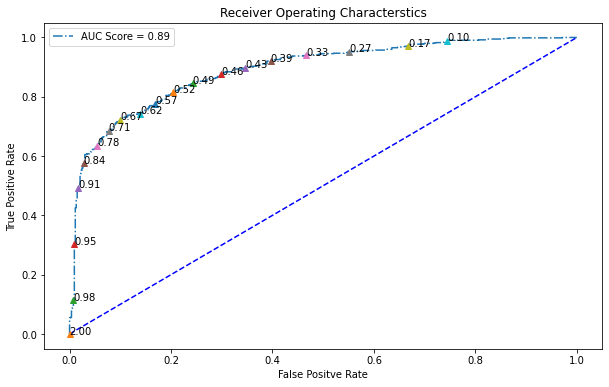

In [215]:
# roc for female
fpr,tpr,thresh = roc_curve(y_test,y_prob[:,1])
auc_s = auc(fpr,tpr)
plt.figure(figsize=(10,6))
plt.plot(fpr,tpr,'-.')
plt.plot([0,1],[0,1],'b--')
for i in range(0,len(thresh),20):
    plt.plot(fpr[i],tpr[i],'^')
    plt.text(fpr[i],tpr[i],"%0.2f"%thresh[i])
    
plt.legend(['AUC Score = %0.2f'%auc_s]) #>80 is very good

plt.xlabel('False Positve Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characterstics')
plt.show()

In [214]:
pickle.dump(model_best,open('svm.pickle','wb'))
pickle.dump(mean,open('./model/mean_data_preprocess.pickle','wb'))